In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [ ]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [ ]:
# Download the Dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2022-05-05 05:55:58--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.188.208, 142.250.73.240, 172.217.15.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.188.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2022-05-05 05:55:58 (53.3 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



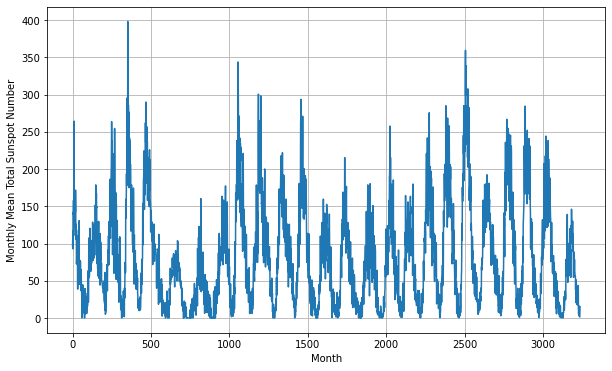

In [ ]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

In [ ]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [ ]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1,
                               activation='relu',
                               padding='causal',
                               input_shape=[window_size,1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),  
        tf.keras.layers.Dense(1), 
        tf.keras.layers.Lambda(lambda x: x*400)                                                 
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [ ]:
init_weights = model.get_weights()
# init_weights

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 13s 67ms/step - loss: 55.9768 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 4s 37ms/step - loss: 55.9086 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 4s 37ms/step - loss: 55.8338 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 4s 37ms/step - loss: 55.7536 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 4s 37ms/step - loss: 55.6662 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 4s 37ms/step - loss: 55.5717 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 4s 37ms/step - loss: 55.4727 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 4s 37ms/step - loss: 55.3664 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 4s 37ms/step - loss: 55.2530 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 4s 37ms/step - loss: 55.1375 - lr: 2.8184e-08
Epoch 11

(1e-08, 0.001, 0.0, 100.0)

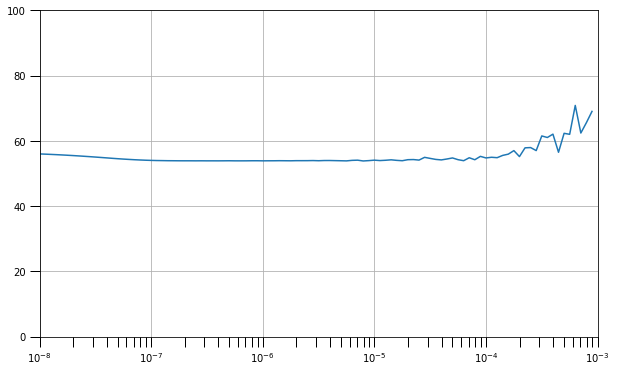

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [ ]:
tf.keras.backend.clear_session()

model.set_weights(init_weights)

In [ ]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
history = model.fit(train_set,epochs=10)

Epoch 1/10
93/93 [==============================] - 4s 38ms/step - loss: 17.1274 - mae: 17.6187
Epoch 2/10
93/93 [==============================] - 4s 37ms/step - loss: 17.1382 - mae: 17.6305
Epoch 3/10
93/93 [==============================] - 4s 37ms/step - loss: 16.8989 - mae: 17.3900
Epoch 4/10
93/93 [==============================] - 4s 37ms/step - loss: 16.9060 - mae: 17.3966
Epoch 5/10
93/93 [==============================] - 4s 37ms/step - loss: 16.9737 - mae: 17.4638
Epoch 6/10
93/93 [==============================] - 4s 38ms/step - loss: 17.1453 - mae: 17.6377
Epoch 7/10
93/93 [==============================] - 4s 38ms/step - loss: 16.8845 - mae: 17.3757
Epoch 8/10
93/93 [==============================] - 4s 38ms/step - loss: 16.8957 - mae: 17.3879
Epoch 9/10
93/93 [==============================] - 4s 37ms/step - loss: 16.9629 - mae: 17.4546
Epoch 10/10
93/93 [==============================] - 4s 38ms/step - loss: 17.0170 - mae: 17.5091


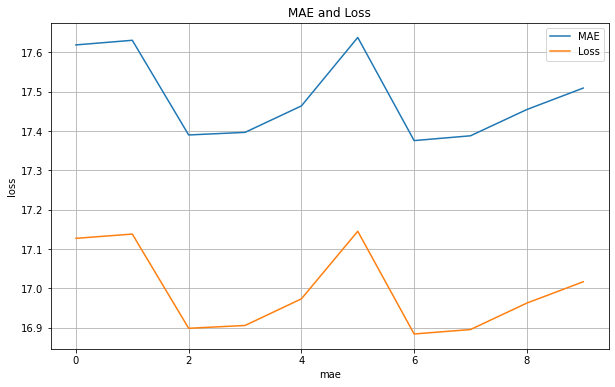

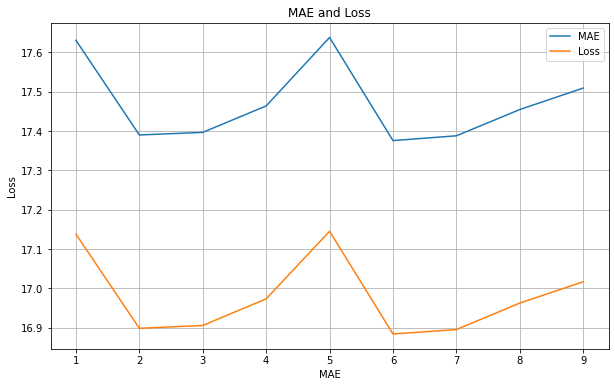

In [ ]:
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))

plot_series(
    x=epochs,
    y=(mae,loss),
    title='MAE and Loss',
    xlabel='mae',
    ylabel='loss',
    legend=['MAE', 'Loss'])

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

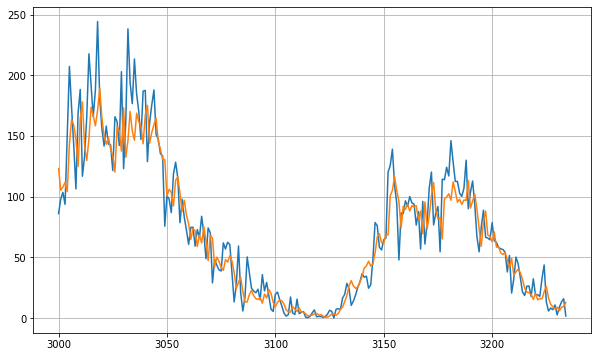

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.519966


In [ ]:
initial_learning_rate=1e-7

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(train_set, epochs=40)

Epoch 1/40
93/93 [==============================] - 8s 38ms/step - loss: 16.5643 - mae: 17.0555
Epoch 2/40
93/93 [==============================] - 4s 37ms/step - loss: 16.5063 - mae: 16.9978
Epoch 3/40
93/93 [==============================] - 4s 37ms/step - loss: 16.4422 - mae: 16.9326
Epoch 4/40
93/93 [==============================] - 4s 44ms/step - loss: 16.4686 - mae: 16.9595
Epoch 5/40
93/93 [==============================] - 4s 37ms/step - loss: 16.4665 - mae: 16.9562
Epoch 6/40
93/93 [==============================] - 4s 43ms/step - loss: 16.4426 - mae: 16.9333
Epoch 7/40
93/93 [==============================] - 4s 38ms/step - loss: 16.4366 - mae: 16.9265
Epoch 8/40
93/93 [==============================] - 4s 37ms/step - loss: 16.4582 - mae: 16.9490
Epoch 9/40
93/93 [==============================] - 4s 37ms/step - loss: 16.4471 - mae: 16.9392
Epoch 10/40
93/93 [==============================] - 4s 37ms/step - loss: 16.4512 - mae: 16.9408
Epoch 11/40
93/93 [====================

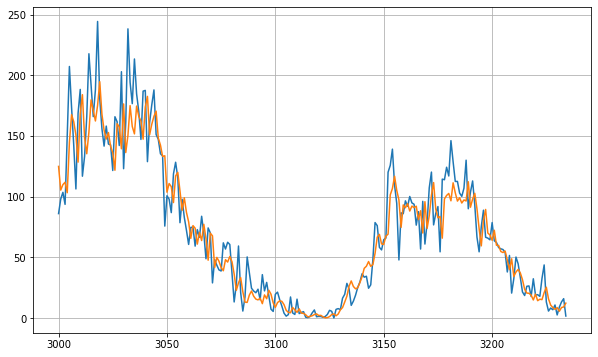

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.411457